In [7]:
import os
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow as pa
import pyarrow.parquet as pq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    MultiLabelBinarizer,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer
)

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import f1_score, classification_report


In [8]:
# general configuration  
USE_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_GPU else "cpu")

# controls dataset streaming
BATCH_START = 1
BATCH_END = 15

# expected column names for Model 3
TARGET_COL = "event_categories"
FEATURE_COLS = [
    "age","sex","drug","gene","approval_year","regulatory_complexity",
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
]


In [9]:
base_dir = Path("data")
assert base_dir.exists(), "Base directory not found."


In [10]:
def set_seed(s=42):
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

set_seed(42)


In [11]:
def normalize_labels(x):
    if isinstance(x, np.ndarray):
        return x.tolist()
    elif isinstance(x, list):
        return x
    else:
        return [x]

class BatchDataLoader:
    def __init__(self, base_dir, start=1, end=15, target_col="event_categories"):
        self.base_dir = Path(base_dir)
        self.start = start
        self.end = end
        self.target_col = target_col
        self.mlb = None

    def _load_parquet(self, i):
        fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
        return pd.read_parquet(fp, engine="pyarrow")

    def iter_batches(self):
        for i in range(self.start, self.end + 1):
            df = self._load_parquet(i)
    
            # normalize EVERY entry before MLP sees it
            labels = df[self.target_col].apply(normalize_labels)
    
            if self.mlb is None:
                self.mlb = MultiLabelBinarizer()
                y = self.mlb.fit_transform(labels)
            else:
                y = self.mlb.transform(labels)
    
            X = df[FEATURE_COLS].copy()
            yield X, y



In [12]:
def inspect_label_space(base_dir, start=1, end=15, target_col="event_categories"):
    vocab = set()

    for i in range(start, end + 1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        df = pd.read_parquet(fp, engine="pyarrow")

        for lst in df[target_col]:
            # Convert numpy arrays → lists
            if isinstance(lst, np.ndarray):
                lst = lst.tolist()

            if isinstance(lst, list):
                vocab.update(lst)
            else:
                vocab.add(lst)

    return sorted(vocab)


label_space = inspect_label_space(base_dir, BATCH_START, BATCH_END, TARGET_COL)
label_space


['admin_use_issues',
 'cardiac',
 'dermatologic_immunologic',
 'endocrine_metabolic',
 'ent_oral',
 'general_symptoms',
 'gi',
 'hepatic',
 'infection_inflammation',
 'musculoskeletal',
 'neuro',
 'oncology_disease_course',
 'ophthalmologic',
 'other',
 'pregnancy_perinatal',
 'psychiatric',
 'renal',
 'respiratory',
 'vascular_hematologic',
 'vitals_labs_bp']

In [13]:
def sample_from_batches(base_dir, n=5000, start=1, end=15):
    out = []

    k = max(1, n // (end - start + 1))

    for i in range(start, end + 1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        df = pd.read_parquet(fp, engine="pyarrow")
        if len(df) <= k:
            out.append(df)
        else:
            out.append(df.sample(k, random_state=42))

    return pd.concat(out, ignore_index=True)

sample_df = sample_from_batches(base_dir, n=5000, start=BATCH_START, end=BATCH_END)
sample_df.head()


,case_id,drug,gene,expr_liver,expr_kidney,expr_colon,expr_intestine,expr_blood,age,sex,evidence_level,association_type,approval_year,regulatory_complexity,event_count,has_severe_event,has_cardiac_event,has_gi_event,max_severity,event_categories
0,24010699,cytarabine,LINC00251,0.003172,0.000327,0.000402,0.001319,0.000393,54.0,M,ClinicalAnnotation,associated,1969,1.190476,9,False,False,False,unknown,"[admin_use_issues, renal, other]"
1,24858496,clozapine,HLA-DRB5,17.320620,76.074093,58.214340,156.184608,138.765915,NaN,M,VariantAnnotation,associated,1996,3.769231,1,False,False,False,unknown,[other]
2,25159730,carboplatin,ERBB2,16.120552,60.444768,56.695122,53.030752,2.609658,68.0,F,ClinicalAnnotation,associated,2004,3.242424,1,False,False,False,unknown,[other]
3,22182618,prednisone,BMP7,0.027938,5.084233,2.955913,2.521455,0.030588,NaN,F,ClinicalAnnotation,associated,1971,1.407407,5,False,False,False,unknown,"[other, admin_use_issues, hepatic]"
4,25103181,gemcitabine,RRM1,5.889108,7.884960,20.669093,20.217237,5.883072,NaN,None,"ClinicalAnnotation,Literature,MultilinkAnnotation",ambiguous,2005,1.000000,1,False,False,True,unknown,[gi]


In [14]:
loader = BatchDataLoader(
    base_dir=base_dir,
    start=BATCH_START,
    end=BATCH_END,
    target_col=TARGET_COL
)


In [15]:
# compute category frequencies on a representative sample
df = sample_df.copy()

freq = {}

for item in df[TARGET_COL]:
    # normalize to list
    if isinstance(item, np.ndarray):
        item = item.tolist()
    elif not isinstance(item, list):
        item = [item]

    for c in item:
        freq[c] = freq.get(c, 0) + 1

freq = pd.Series(freq).sort_values(ascending=False)
freq



other                       3773
admin_use_issues            1649
general_symptoms            1154
infection_inflammation      1016
gi                           843
vascular_hematologic         834
dermatologic_immunologic     737
respiratory                  724
neuro                        571
musculoskeletal              482
psychiatric                  443
hepatic                      364
renal                        350
cardiac                      344
vitals_labs_bp               337
endocrine_metabolic          266
ent_oral                     246
oncology_disease_course      230
pregnancy_perinatal          122
ophthalmologic                98
dtype: int64

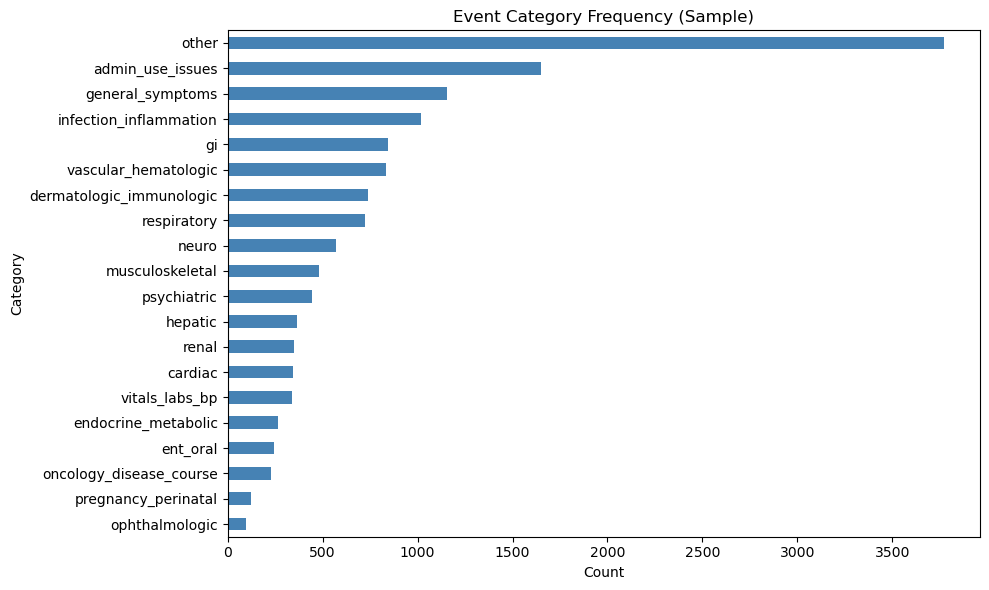

In [16]:

plt.figure(figsize=(10, 6))
freq.sort_values().plot(kind="barh", color="steelblue")
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Event Category Frequency (Sample)")
plt.tight_layout()
plt.savefig(
    "fig_event_category_frequency_raw.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [17]:
cats = sorted(freq.index)
idx = {c: i for i, c in enumerate(cats)}

M = np.zeros((len(cats), len(cats)), dtype=np.int64)

for item in df[TARGET_COL]:
    # normalize to list
    if isinstance(item, np.ndarray):
        item = item.tolist()
    elif not isinstance(item, list):
        item = [item]

    unique = list(set(item))

    for a in unique:
        for b in unique:
            M[idx[a], idx[b]] += 1

cooc = pd.DataFrame(M, index=cats, columns=cats)
cooc


,admin_use_issues,cardiac,dermatologic_immunologic,endocrine_metabolic,ent_oral,general_symptoms,gi,hepatic,infection_inflammation,musculoskeletal,neuro,oncology_disease_course,ophthalmologic,other,pregnancy_perinatal,psychiatric,renal,respiratory,vascular_hematologic,vitals_labs_bp
admin_use_issues,1649,144,353,155,124,502,349,152,423,275,291,97,56,1209,62,239,109,317,265,152
cardiac,144,344,144,76,70,198,149,60,146,111,134,12,34,294,20,112,35,161,100,109
dermatologic_immunologic,353,144,737,161,169,437,336,136,300,273,279,12,44,603,54,218,49,292,164,163
endocrine_metabolic,155,76,161,266,97,203,180,77,155,139,156,6,33,251,33,128,22,145,85,101
ent_oral,124,70,169,97,246,194,190,83,144,118,137,6,27,217,34,110,18,176,76,87
general_symptoms,502,198,437,203,194,1154,560,161,397,375,391,35,66,999,57,341,87,407,253,228
gi,349,149,336,180,190,560,843,143,327,263,309,28,55,727,50,227,75,310,199,167
hepatic,152,60,136,77,83,161,143,364,160,126,120,13,21,289,53,107,30,134,99,92
infection_inflammation,423,146,300,155,144,397,327,160,1016,245,252,42,46,834,51,192,109,469,287,171
musculoskeletal,275,111,273,139,118,375,263,126,245,482,235,6,49,433,52,192,32,245,118,156


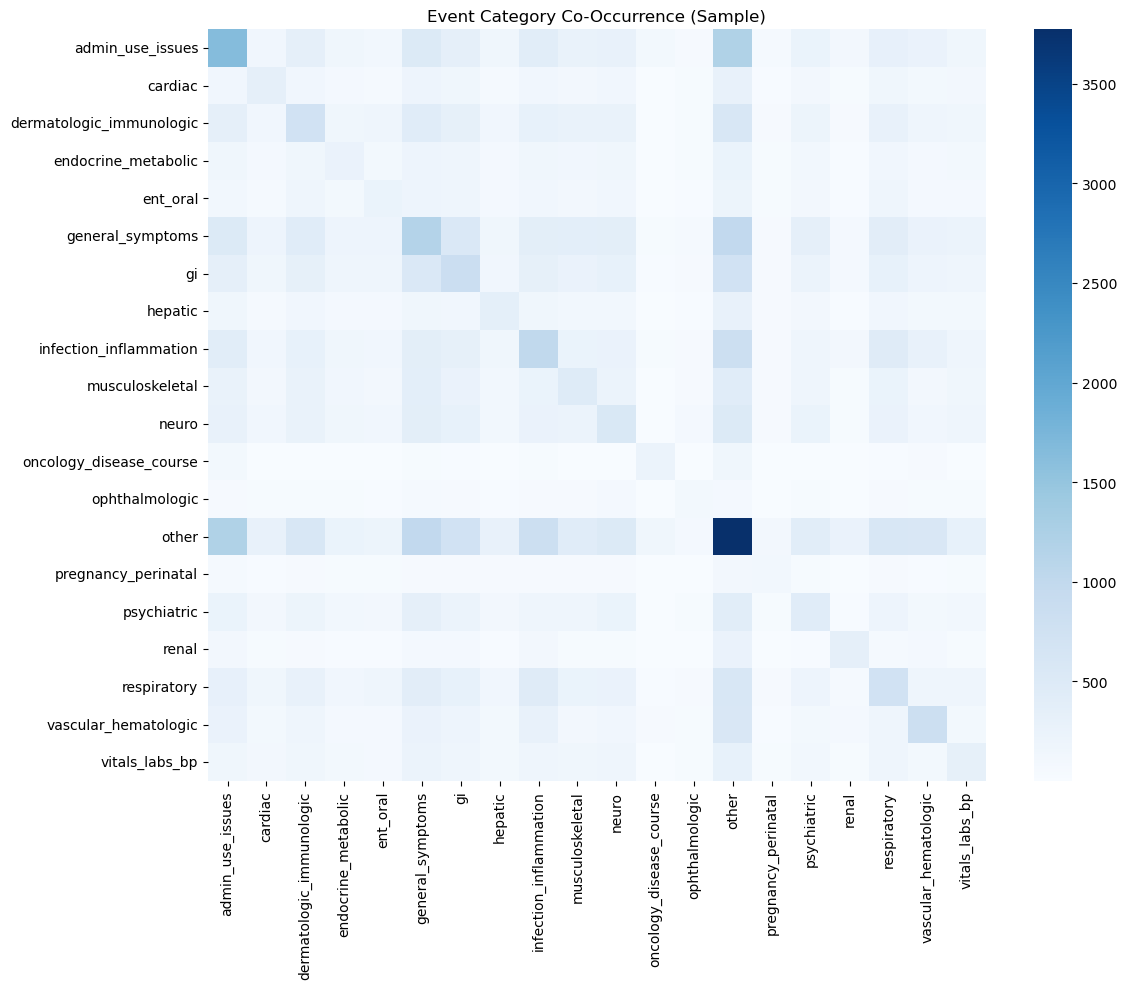

In [18]:

plt.figure(figsize=(12, 10))
sns.heatmap(cooc, cmap="Blues")
plt.title("Event Category Co-Occurrence (Sample)")
plt.tight_layout()
plt.show()


In [19]:
subset = df.copy()

# count category per drug
drug_counts = {}

for drug, lst in zip(subset["drug"], subset[TARGET_COL]):
    lst = normalize_labels(lst)

    for c in lst:
        drug_counts.setdefault(drug, {})
        drug_counts[drug][c] = drug_counts[drug].get(c, 0) + 1

drug_df = pd.DataFrame(drug_counts).fillna(0)
drug_df.head()





,cytarabine,clozapine,carboplatin,prednisone,gemcitabine,cisplatin,aripiprazole,olanzapine,letrozole,azacitidine,...,acetazolamide,triamcinolone,fenofibrate,eplerenone,methylprednisolone,isotretinoin,promethazine,colchicine,thiotepa,cidofovir
admin_use_issues,16.0,24.0,45.0,63,18.0,42.0,16.0,44.0,2.0,1.0,...,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,5.0,4.0
renal,4.0,1.0,19.0,4,2.0,12.0,1.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
other,34.0,45.0,142.0,106,32.0,88.0,24.0,110.0,11.0,5.0,...,0.0,2.0,1.0,0.0,2.0,1.0,1.0,1.0,11.0,2.0
infection_inflammation,10.0,2.0,30.0,50,2.0,19.0,2.0,18.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0
vascular_hematologic,14.0,17.0,52.0,19,11.0,39.0,2.0,17.0,4.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


In [20]:
# count category per gene
gene_counts = {}

for gene, lst in zip(subset["gene"], subset[TARGET_COL]):
    lst = normalize_labels(lst)

    for c in lst:
        gene_counts.setdefault(gene, {})
        gene_counts[gene][c] = gene_counts[gene].get(c, 0) + 1

gene_df = pd.DataFrame(gene_counts).fillna(0)
gene_df.head()

,LINC00251,HLA-DRB5,ERBB2,BMP7,RRM1,OTOS,HLA-B,CYP2C9,ESR1,CBL,...,SPOPL,HSPA1A,HINT1,CYP2A7P1,PLEKHA6,ATP5F1E,ARHGAP9,SULT2B1,F3,GSK3B
admin_use_issues,18,0.0,2.0,17,1.0,0.0,15,20.0,2.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
renal,3,0.0,0.0,3,2.0,0.0,4,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
other,27,3.0,7.0,30,4.0,4.0,41,28.0,8.0,2.0,...,1.0,2.0,0.0,4.0,2.0,4.0,2.0,3.0,4.0,1.0
cardiac,3,0.0,2.0,5,1.0,1.0,2,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
infection_inflammation,16,0.0,1.0,11,0.0,1.0,2,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0


In [21]:
def strip_other(lst):
    if isinstance(lst, list):
        out = [x for x in lst if x != "other"]
        return out
    if isinstance(lst, str):
        return [] if lst == "other" else [lst]
    if isinstance(lst, np.ndarray):
        out = [x for x in lst.tolist() if x != "other"]
        return out
    return []


In [22]:
class BatchDataLoader:
    def __init__(self, base_dir, start=1, end=15, target_col="event_categories"):
        self.base_dir = Path(base_dir)
        self.start = start
        self.end = end
        self.target_col = target_col
        self.mlb = None

    def _load_parquet(self, i):
        fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
        return pd.read_parquet(fp, engine="pyarrow")

    def iter_batches(self):
        for i in range(self.start, self.end + 1):
            df = self._load_parquet(i)

            # remove "other"
            lbl = df[self.target_col].apply(strip_other)

            # drop empty rows
            keep = lbl.apply(lambda x: len(x) > 0)
            df = df[keep]
            lbl = lbl[keep]

            if self.mlb is None:
                self.mlb = MultiLabelBinarizer()
                y = self.mlb.fit_transform(lbl)
            else:
                y = self.mlb.transform(lbl)

            X = df[FEATURE_COLS].copy()
            yield X, y


In [23]:
def sample_without_other(base_dir, n=5000, start=1, end=15):
    out = []
    k = max(1, n // (end - start + 1))

    for i in range(start, end + 1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        df = pd.read_parquet(fp, engine="pyarrow")

        # remove other
        lbl = df[TARGET_COL].apply(strip_other)
        keep = lbl.apply(lambda x: len(x) > 0)

        df = df[keep].copy()
        df[TARGET_COL] = lbl[keep]

        if len(df) <= k:
            out.append(df)
        else:
            out.append(df.sample(k, random_state=42))

    return pd.concat(out, ignore_index=True)

df_clean = sample_without_other(base_dir, n=5000, start=BATCH_START, end=BATCH_END)
df_clean.head()


,case_id,drug,gene,expr_liver,expr_kidney,expr_colon,expr_intestine,expr_blood,age,sex,evidence_level,association_type,approval_year,regulatory_complexity,event_count,has_severe_event,has_cardiac_event,has_gi_event,max_severity,event_categories
0,24331335,prednisone,BMP7,0.027938,5.084233,2.955913,2.521455,0.030588,NaN,None,ClinicalAnnotation,associated,1971,1.407407,2,False,False,False,unknown,[respiratory]
1,24993451,risperidone,SLC6A4,0.047351,0.223579,0.316850,9.215442,0.189376,14.0,M,"ClinicalAnnotation,MultilinkAnnotation,Variant...",ambiguous,2008,4.163265,4,False,False,True,unknown,[gi]
2,23637310,methotrexate,MTRR,9.103740,10.509697,12.584720,14.046262,4.587057,NaN,None,"ClinicalAnnotation,MultilinkAnnotation",associated,2020,1.000000,3,False,True,False,unknown,"[cardiac, infection_inflammation]"
3,20347289,aripiprazole,HLA-B,540.959418,1231.923519,1751.140806,2830.483657,9209.872868,NaN,F,MultilinkAnnotation,ambiguous,2015,4.000000,3,False,False,False,unknown,[admin_use_issues]
4,23418582,dexamethasone,PYGL,63.659408,12.197101,28.720291,14.851918,470.702088,89.0,M,ClinicalAnnotation,associated,1971,1.640000,1,False,False,False,unknown,"[psychiatric, neuro]"


In [24]:
freq_clean = {}
for item in df_clean[TARGET_COL]:
    for c in item:
        freq_clean[c] = freq_clean.get(c, 0) + 1

freq_clean = pd.Series(freq_clean).sort_values(ascending=False)
freq_clean


admin_use_issues            2143
general_symptoms            1617
infection_inflammation      1287
gi                          1064
dermatologic_immunologic    1054
vascular_hematologic        1043
respiratory                  954
neuro                        785
musculoskeletal              687
psychiatric                  567
hepatic                      454
vitals_labs_bp               444
cardiac                      407
renal                        370
endocrine_metabolic          341
ent_oral                     317
oncology_disease_course      301
pregnancy_perinatal          194
ophthalmologic               146
dtype: int64

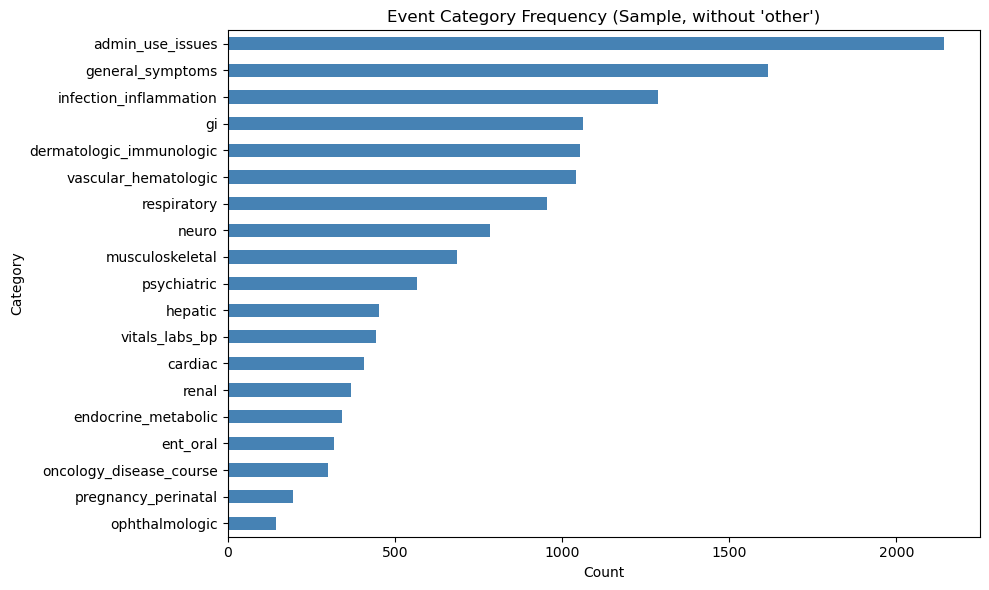

In [25]:
plt.figure(figsize=(10, 6))
freq_clean.sort_values().plot(kind="barh", color="steelblue")
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Event Category Frequency (Sample, without 'other')")
plt.tight_layout()
plt.savefig(
    "fig_event_category_frequency_clean.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [26]:
cats = sorted(freq_clean.index)
idx = {c: i for i, c in enumerate(cats)}

M = np.zeros((len(cats), len(cats)), dtype=np.int64)

for item in df_clean[TARGET_COL]:
    u = list(set(item))
    for a in u:
        for b in u:
            M[idx[a], idx[b]] += 1

cooc_clean = pd.DataFrame(M, index=cats, columns=cats)
cooc_clean


,admin_use_issues,cardiac,dermatologic_immunologic,endocrine_metabolic,ent_oral,general_symptoms,gi,hepatic,infection_inflammation,musculoskeletal,neuro,oncology_disease_course,ophthalmologic,pregnancy_perinatal,psychiatric,renal,respiratory,vascular_hematologic,vitals_labs_bp
admin_use_issues,2143,150,494,193,161,687,486,201,556,373,404,123,66,109,284,119,424,317,216
cardiac,150,407,192,92,91,266,176,69,183,152,177,10,50,34,139,39,200,123,146
dermatologic_immunologic,494,192,1054,202,224,636,471,196,415,413,396,30,90,98,289,74,407,260,255
endocrine_metabolic,193,92,202,341,123,259,219,103,187,173,196,13,37,48,151,19,182,111,116
ent_oral,161,91,224,123,317,241,251,114,202,176,191,5,37,61,160,15,231,105,132
general_symptoms,687,266,636,259,241,1617,739,223,588,564,561,51,102,100,467,105,567,372,307
gi,486,176,471,219,251,739,1064,206,426,383,421,31,80,92,296,71,392,284,228
hepatic,201,69,196,103,114,223,206,454,207,179,169,11,21,82,146,35,186,122,128
infection_inflammation,556,183,415,187,202,588,426,207,1287,358,364,47,81,83,279,114,650,352,227
musculoskeletal,373,152,413,173,176,564,383,179,358,687,341,11,76,96,261,44,343,171,213


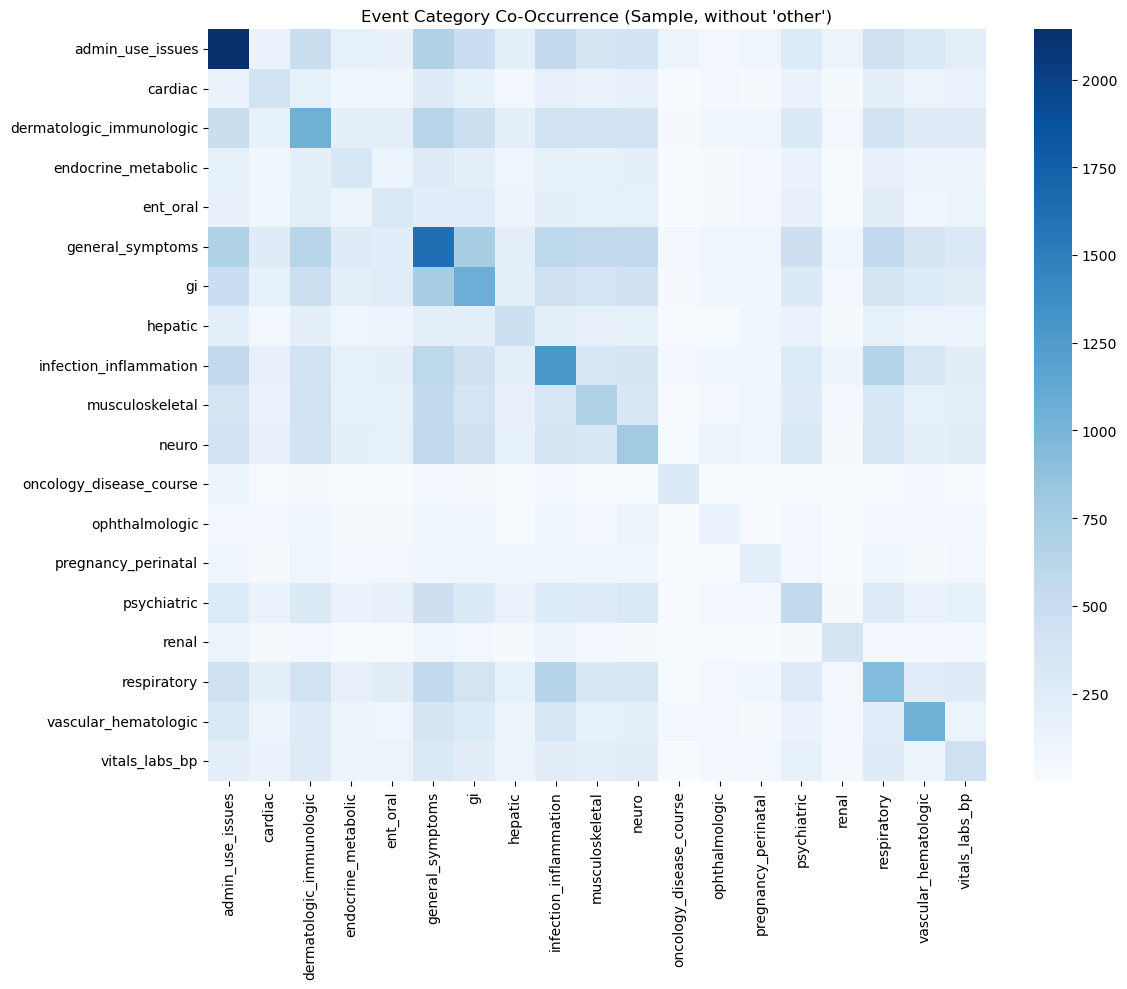

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_clean, cmap="Blues")
plt.title("Event Category Co-Occurrence (Sample, without 'other')")
plt.tight_layout()
plt.show()


In [23]:
def clean_cats(df):
    out = df.copy()
    for c in ["sex", "drug", "gene"]:
        out[c] = out[c].astype(str).fillna("missing")
    return out

In [24]:

cat_cols = ["sex", "drug", "gene"]
num_cols = [
    "age","approval_year","regulatory_complexity",
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
]

preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]), num_cols)
])

In [25]:
def remove_other(lbl):
    if isinstance(lbl, list):
        return [x for x in lbl if x != "other"]
    if isinstance(lbl, np.ndarray):
        return [x for x in lbl.tolist() if x != "other"]
    if isinstance(lbl, str):
        return [] if lbl == "other" else [lbl]
    return []


In [26]:
# load one batch
loader_test = BatchDataLoader(
    base_dir=base_dir,
    start=BATCH_START,
    end=BATCH_START,
    target_col=TARGET_COL
)

X_batch, y_raw = next(loader_test.iter_batches())

# check whether "other" exists
classes = list(loader_test.mlb.classes_)

if "other" in classes:
    other_idx = classes.index("other")

    # remove "other" column
    y_clean = np.delete(y_raw, other_idx, axis=1)

    # drop rows that became empty
    keep = y_clean.sum(axis=1) > 0

    X_clean = X_batch.iloc[keep].reset_index(drop=True)
    y_clean = y_clean[keep]
else:
    # "other" already removed upstream
    X_clean = X_batch.reset_index(drop=True)
    y_clean = y_raw

X_clean.shape, y_clean.shape


((1194161, 11), (1194161, 19))

In [27]:
Xb = clean_cats(X_clean)

# pipe_lr = Pipeline([
#     ("preproc", preproc),
#     ("clf", OneVsRestClassifier(
#         LogisticRegression(
#             max_iter=300,
#             n_jobs=-1,
#             class_weight="balanced"
#         )
#     ))
# ])

# pipe_lr.fit(Xb, y_clean)
# pred_lr = pipe_lr.predict(Xb)

# f1_micro_lr = f1_score(y_clean, pred_lr, average="micro")
# f1_macro_lr = f1_score(y_clean, pred_lr, average="macro")

# f1_micro_lr, f1_macro_lr

# # (0.3316941295379641, 0.3037921979722492) with other


In [28]:
# # numeric and categorical setup
# cat_cols = ["sex", "drug", "gene"]
# num_cols = [
#     "age","approval_year","regulatory_complexity",
#     "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
# ]

# # convert categoricals into strings for hashing
# def combine_cats(df):
#     return df[cat_cols].astype(str).agg(" ".join, axis=1)

# hash_vec = HashingVectorizer(
#     n_features=2**18,
#     alternate_sign=False,
#     norm=None
# )

# hash_pipe = Pipeline([
#     ("combine", FunctionTransformer(combine_cats, validate=False)),
#     ("hash", hash_vec)
# ])

# num_pipe = Pipeline([
#     ("imp", SimpleImputer(strategy="mean")),
#     ("sc", StandardScaler())
# ])

# preproc = ColumnTransformer([
#     ("hash", hash_pipe, cat_cols),
#     ("num", num_pipe, num_cols)
# ])

# clf = OneVsRestClassifier(
#     LogisticRegression(
#         max_iter=300,
#         n_jobs=-1,
#         class_weight="balanced"
#     )
# )

# pipe = Pipeline([
#     ("preproc", preproc),
#     ("clf", clf)
# ])

# pipe.fit(Xb, y_clean)

# pred = pipe.predict(Xb)
# f1_micro = f1_score(y_clean, pred, average="micro")
# f1_macro = f1_score(y_clean, pred, average="macro")

# f1_micro, f1_macro

# # (0.3261483974324744, 0.29913243491288594) with other


In [29]:
from collections import defaultdict

def build_vocab(base_dir, start, end):
    drug_set = set()
    gene_set = set()
    sex_set = set()

    for i in range(start, end+1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        df = pd.read_parquet(fp, engine="pyarrow")
        df["sex"] = df["sex"].astype(str).fillna("missing")

        drug_set.update(df["drug"].astype(str).tolist())
        gene_set.update(df["gene"].astype(str).tolist())
        sex_set.update(df["sex"].astype(str).tolist())

    drug2id = {d:i for i,d in enumerate(sorted(drug_set))}
    gene2id = {g:i for i,g in enumerate(sorted(gene_set))}
    sex2id  = {s:i for i,s in enumerate(sorted(sex_set))}

    return drug2id, gene2id, sex2id

drug2id, gene2id, sex2id = build_vocab(base_dir, BATCH_START, BATCH_END)
len(drug2id), len(gene2id), len(sex2id)


(373, 824, 4)

In [30]:
num_cols = [
    "age","approval_year","regulatory_complexity",
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
]

def compute_num_stats(base_dir, start, end):
    s = np.zeros(len(num_cols))
    ss = np.zeros(len(num_cols))
    n = 0

    for i in range(start, end+1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        df = pd.read_parquet(fp, engine="pyarrow")
        
        df = df[num_cols].copy()
        df["age"] = df["age"].fillna(df["age"].median())

        x = df[num_cols].values
        s += x.sum(axis=0)
        ss += (x*x).sum(axis=0)
        n += len(df)

    mean = s/n
    std = np.sqrt(ss/n - mean**2)
    std[std < 1e-6] = 1.0
    return mean, std

num_mean, num_std = compute_num_stats(base_dir, BATCH_START, BATCH_END)
num_mean, num_std


(array([  53.83282827, 1997.16367066,    2.04432034,  101.37732202,
          44.47533773,   51.43003624,   84.9363859 ,  174.99138923]),
 array([  18.36995725,   17.78798296,    1.12891762,  366.95945531,
         187.13988674,  209.21133615,  320.48943933, 1040.2153688 ]))

In [31]:
class ParquetDataset3(torch.utils.data.Dataset):
    def __init__(self, df, drug2id, gene2id, sex2id, num_mean, num_std, mlb):
        self.df = df
        self.drug2id = drug2id
        self.gene2id = gene2id
        self.sex2id  = sex2id
        self.num_mean = num_mean
        self.num_std  = num_std
        self.mlb = mlb
        
        self.num_cols = num_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        d = self.drug2id[row["drug"]]
        g = self.gene2id[row["gene"]]
        s = self.sex2id[str(row["sex"])]

        num = row[self.num_cols].values.astype(np.float32)
        num = (num - self.num_mean) / self.num_std

        y = self.mlb.transform([row["event_categories"]])[0].astype(np.float32)

        return (
            torch.tensor(d, dtype=torch.long),
            torch.tensor(g, dtype=torch.long),
            torch.tensor(s, dtype=torch.long),
            torch.tensor(num, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )


In [32]:
def load_clean_batch(i, loader):
    X, y = next(loader.iter_batches())
    df = X.copy()
    df["event_categories"] = loader.mlb.inverse_transform(y)
    df["event_categories"] = df["event_categories"].apply(list)
    return df, loader.mlb


In [33]:
class Model3Net(nn.Module):
    def __init__(self, nD, nG, nS, n_num, n_labels):
        super().__init__()

        # Embeddings sized to categorical entropy
        self.ed = nn.Embedding(nD, 128)
        self.eg = nn.Embedding(nG, 128)
        self.es = nn.Embedding(nS, 8)

        self.lin_num = nn.Linear(n_num, 64)

        self.norm_cat = nn.LayerNorm(128 + 128 + 8)
        self.norm_num = nn.LayerNorm(64)

        self.f1 = nn.Linear(328, 384)
        self.f2 = nn.Linear(384, n_labels)

        # Per-class bias for imbalance correction
        self.logit_bias = nn.Parameter(torch.zeros(n_labels))

    def forward(self, d, g, s, num):
        xd = self.ed(d)
        xg = self.eg(g)
        xs = self.es(s)

        x_cat = torch.cat([xd, xg, xs], dim=-1)
        x_cat = self.norm_cat(x_cat)

        x_num = self.norm_num(self.lin_num(num))

        x = torch.cat([x_cat, x_num], dim=-1)
        x = F.relu(self.f1(x))
        logits = self.f2(x) + self.logit_bias

        return logits


In [34]:
def compute_pos_weight(
    base_dir,
    start,
    end,
    frac,
    mlb,
    max_rows=200_000
):
    counts = np.zeros(len(mlb.classes_), dtype=np.float64)
    total = 0

    rng = np.random.RandomState(42)

    for i in range(start, end + 1):
        fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
        if not fp.exists():
            continue

        pq_file = pq.ParquetFile(fp)

        for batch in pq_file.iter_batches(
            batch_size=2048,
            columns=["event_categories"]
        ):
            df = batch.to_pandas()

            # subsample rows
            if frac < 1.0:
                mask = rng.rand(len(df)) < frac
                df = df[mask]

            for lst in df["event_categories"]:
                labels = normalize_evt(lst)
                if len(labels) == 0:
                    continue

                idxs = mlb.transform([labels])[0].nonzero()[0]
                counts[idxs] += 1
                total += 1

                if total >= max_rows:
                    break

            if total >= max_rows:
                break

        if total >= max_rows:
            break

    pos = counts
    neg = total - counts
    pos_weight = neg / np.maximum(pos, 1.0)

    return torch.tensor(pos_weight, dtype=torch.float32)



def train_model(
    model,
    train_loader,
    val_loader,
    pos_weight,
    device,
    lr=1e-3,
    max_epochs=15,
    patience=3
):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    best_state = None
    best_macro = -1.0
    bad_epochs = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0

        for d, g, s, num, y in train_loader:
            d, g, s, num, y = (
                d.to(device),
                g.to(device),
                s.to(device),
                num.to(device),
                y.to(device)
            )

            opt.zero_grad()
            logits = model(d, g, s, num)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_micro, val_macro = evaluate(model, val_loader, device)

        if val_macro > best_macro:
            best_macro = val_macro
            best_state = deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(
            f"epoch {epoch:02d} | "
            f"train_loss {total_loss:.4f} | "
            f"val_micro {val_micro:.4f} | "
            f"val_macro {val_macro:.4f}"
        )

        if bad_epochs >= patience:
            break

    model.load_state_dict(best_state)
    return model

def tune_thresholds(y_true, y_prob):
    n_labels = y_true.shape[1]
    thresholds = np.zeros(n_labels)

    for k in range(n_labels):
        best_f1 = -1.0
        best_t = 0.5
        for t in np.linspace(0.05, 0.95, 19):
            pred = (y_prob[:, k] > t).astype(int)
            f1 = f1_score(y_true[:, k], pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        thresholds[k] = best_t

    return thresholds

def evaluate(model, loader, device, thresholds=None):
    model.eval()
    ys = []
    ps = []

    with torch.no_grad():
        for d, g, s, num, y in loader:
            d, g, s, num = (
                d.to(device),
                g.to(device),
                s.to(device),
                num.to(device)
            )
            logits = model(d, g, s, num)
            prob = torch.sigmoid(logits).cpu().numpy()

            ys.append(y.numpy())
            ps.append(prob)

    ys = np.vstack(ys)
    ps = np.vstack(ps)

    if thresholds is None:
        pred = (ps > 0.5).astype(int)
    else:
        pred = (ps > thresholds).astype(int)

    micro = f1_score(ys, pred, average="micro", zero_division=0)
    macro = f1_score(ys, pred, average="macro", zero_division=0)

    return micro, macro


In [35]:
def normalize_evt(x):
    if isinstance(x, list):
        return [y for y in x if y != "other"]
    if isinstance(x, np.ndarray):
        return [y for y in x.tolist() if y != "other"]
    if isinstance(x, str):
        return [] if x == "other" else [x]
    return []

all_labels = []

for i in range(1, 6):
    fp = Path(base_dir) / f"faers_integration_batch_{i:03d}.parquet"
    df = pd.read_parquet(fp, engine="pyarrow")

    lbl = df["event_categories"].apply(normalize_evt)
    lbl = lbl[lbl.apply(len) > 0]

    all_labels.extend(lbl.tolist())

assert len(all_labels) > 0, "MLB fitted on empty label set"

mlb = MultiLabelBinarizer()
mlb.fit(all_labels)

print("Frozen labels:", mlb.classes_)

Frozen labels: ['admin_use_issues' 'cardiac' 'dermatologic_immunologic'
 'endocrine_metabolic' 'ent_oral' 'general_symptoms' 'gi' 'hepatic'
 'infection_inflammation' 'musculoskeletal' 'neuro'
 'oncology_disease_course' 'ophthalmologic' 'pregnancy_perinatal'
 'psychiatric' 'renal' 'respiratory' 'vascular_hematologic'
 'vitals_labs_bp']


In [36]:
class StreamingParquetDataset(IterableDataset):
    def __init__(self, base_dir, start, end, frac, drug2id, gene2id, sex2id, num_mean, num_std, mlb):
        self.base_dir = Path(base_dir)
        self.start = start
        self.end = end
        self.frac = frac
        self.drug2id = drug2id
        self.gene2id = gene2id
        self.sex2id = sex2id
        self.num_mean = num_mean
        self.num_std = num_std
        self.mlb = mlb
        self.age_median = 53.83

    def _parse_labels(self, val):
        if isinstance(val, list):
            return [x for x in val if x != "other"]
    
        if isinstance(val, np.ndarray):
            return [x for x in val.tolist() if x != "other"]
    
        if isinstance(val, str):
            try:
                parsed = ast.literal_eval(val)
                if isinstance(parsed, list):
                    return [x for x in parsed if x != "other"]
                return [parsed] if parsed != "other" else []
            except:
                return []
    
        return []


    def __iter__(self):
        for i in range(self.start, self.end + 1):
            fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
            if not fp.exists():
                continue
            parquet_file = pq.ParquetFile(fp)
            
            for batch in parquet_file.iter_batches(
                batch_size=2048,
                columns=["drug", "gene", "sex", "age", "approval_year", "regulatory_complexity",
                         "expr_liver", "expr_kidney", "expr_colon", "expr_intestine", "expr_blood",
                         "event_categories"]
            ):
                df = batch.to_pandas()
                
                if self.frac < 1.0:
                    df = df.sample(frac=self.frac, random_state=42).reset_index(drop=True)
                
                for _, row in df.iterrows():
                    labels = self._parse_labels(row["event_categories"])
                    
                    if len(labels) == 0:
                        continue
                    
                    d = self.drug2id[row["drug"]]
                    g = self.gene2id[row["gene"]]
                    s = self.sex2id[str(row.get("sex", "missing"))]
                    
                    age = row.get("age", np.nan)
                    if np.isnan(age):
                        age = self.age_median
                    
                    num = np.array([
                        age,
                        row["approval_year"],
                        row["regulatory_complexity"],
                        row["expr_liver"],
                        row["expr_kidney"],
                        row["expr_colon"],
                        row["expr_intestine"],
                        row["expr_blood"]
                    ], dtype=np.float32)
                    
                    num = (num - self.num_mean) / self.num_std
                    
                    y = self.mlb.transform([labels])[0].astype(np.float32)
                    
                    yield (
                        torch.tensor(d, dtype=torch.long),
                        torch.tensor(g, dtype=torch.long),
                        torch.tensor(s, dtype=torch.long),
                        torch.tensor(num, dtype=torch.float32),
                        torch.tensor(y, dtype=torch.float32)
                    )

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 256
FRAC = 0.1

train_dataset = StreamingParquetDataset(
    base_dir=base_dir,
    start=1,
    end=4,              # train on batches 1–4
    frac=FRAC,
    drug2id=drug2id,
    gene2id=gene2id,
    sex2id=sex2id,
    num_mean=num_mean,
    num_std=num_std,
    mlb=mlb
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=False
)


In [38]:
val_dataset = StreamingParquetDataset(
    base_dir=base_dir,
    start=5,
    end=5,              # held-out batch
    frac=FRAC,
    drug2id=drug2id,
    gene2id=gene2id,
    sex2id=sex2id,
    num_mean=num_mean,
    num_std=num_std,
    mlb=mlb
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=False
)


In [39]:
model = Model3Net(
    nD=len(drug2id),
    nG=len(gene2id),
    nS=len(sex2id),
    n_num=len(num_cols),
    n_labels=len(mlb.classes_)
).to(device)


In [41]:
print("Computing pos_weight for BCE")


pos_weight = compute_pos_weight(
    base_dir=base_dir,
    start=1,
    end=4,
    frac=FRAC,
    mlb=mlb
    # max_batches=10
)

print("pos_weight stats:",
      pos_weight.min().item(),
      pos_weight.mean().item(),
      pos_weight.max().item())


Computing pos_weight for BCE
pos_weight stats: 1.3366669416427612 10.067421913146973 34.85514450073242


In [44]:
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    pos_weight=pos_weight,
    device=device,
    lr=1e-3,
    max_epochs=15,
    patience=3
)


epoch 00 | train_loss 2182.0884 | val_micro 0.3491 | val_macro 0.3253
epoch 01 | train_loss 2157.4209 | val_micro 0.3560 | val_macro 0.3293
epoch 02 | train_loss 2143.5825 | val_micro 0.3584 | val_macro 0.3301
epoch 03 | train_loss 2136.0069 | val_micro 0.3578 | val_macro 0.3299
epoch 04 | train_loss 2127.0749 | val_micro 0.3568 | val_macro 0.3299
epoch 05 | train_loss 2120.8110 | val_micro 0.3563 | val_macro 0.3301
epoch 06 | train_loss 2115.5339 | val_micro 0.3575 | val_macro 0.3297
epoch 07 | train_loss 2110.4357 | val_micro 0.3585 | val_macro 0.3309
epoch 08 | train_loss 2106.6268 | val_micro 0.3611 | val_macro 0.3323
epoch 09 | train_loss 2102.9099 | val_micro 0.3611 | val_macro 0.3320
epoch 10 | train_loss 2098.9697 | val_micro 0.3581 | val_macro 0.3305
epoch 11 | train_loss 2096.5088 | val_micro 0.3615 | val_macro 0.3326
epoch 12 | train_loss 2093.4530 | val_micro 0.3598 | val_macro 0.3316
epoch 13 | train_loss 2090.4654 | val_micro 0.3623 | val_macro 0.3324
epoch 14 | train_los

In [45]:
model.eval()
ys = []
ps = []

with torch.no_grad():
    for d, g, s, num, y in val_loader:
        d, g, s, num = (
            d.to(device),
            g.to(device),
            s.to(device),
            num.to(device)
        )
        logits = model(d, g, s, num)
        prob = torch.sigmoid(logits).cpu().numpy()

        ys.append(y.numpy())
        ps.append(prob)

ys = np.vstack(ys)
ps = np.vstack(ps)

thresholds = tune_thresholds(ys, ps)

print("Threshold range:",
      thresholds.min(),
      thresholds.mean(),
      thresholds.max())


Threshold range: 0.39999999999999997 0.5842105263157894 0.7999999999999999


In [46]:
micro_def, macro_def = evaluate(
    model, val_loader, device, thresholds=None
)

micro_tuned, macro_tuned = evaluate(
    model, val_loader, device, thresholds=thresholds
)

print("DEFAULT threshold:")
print(" micro F1:", micro_def)
print(" macro F1:", macro_def)

print("\nTUNED thresholds:")
print(" micro F1:", micro_tuned)
print(" macro F1:", macro_tuned)


DEFAULT threshold:
 micro F1: 0.3618622612969756
 macro F1: 0.33297610545496675

TUNED thresholds:
 micro F1: 0.4233260529672863
 macro F1: 0.35771724988646164
